# **Dataset Analysis**

In this file, we analyze the dataset to determine if the task is ill-defined.

In [3]:
import pandas as pd
import seaborn as sns

In [5]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

Taking only numerical features used for classification

In [3]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

Reconstruct the dataset

In [4]:
train_data["top_20"] = train_labels["top_20"]
test_data["top_20"] = test_labels["top_20"]

races_df = pd.concat([train_data, test_data], ignore_index=True)

races_df.head()

,climb_total,cyclist_age,cyclist_level,cyclist_experience,avg_relative_position,position_entropy,top_20_entropy,top_20
0,0.027,27.0,0.000000,0,0.000000,0.000000,0.0,0
1,0.438,27.0,73.636364,1,0.263636,0.000000,0.0,0
2,0.398,27.0,91.984987,2,0.540075,1.000000,0.0,0
3,1.847,27.0,138.773978,3,0.537420,1.584963,0.0,0
4,1.705,27.0,194.329534,4,0.514176,2.000000,0.0,0


## PCA

Let's use PCA trying to find some division into data

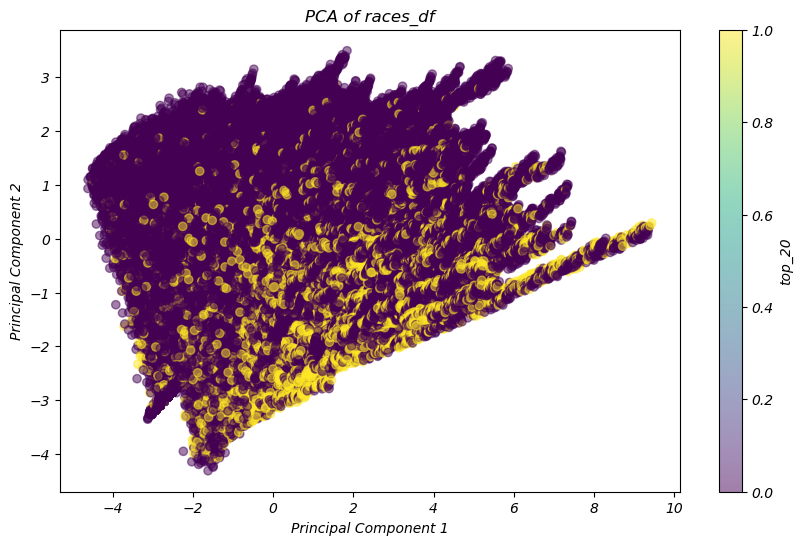

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# select data and scale it
features = races_df.drop(columns=['top_20'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

#  Create a DataFrame with the principal components and plot them
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['top_20'] = races_df['top_20']

plt.figure(figsize=(10,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['top_20'], cmap='viridis', alpha=0.5)
plt.colorbar(label='top_20')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of races_df')
plt.show()


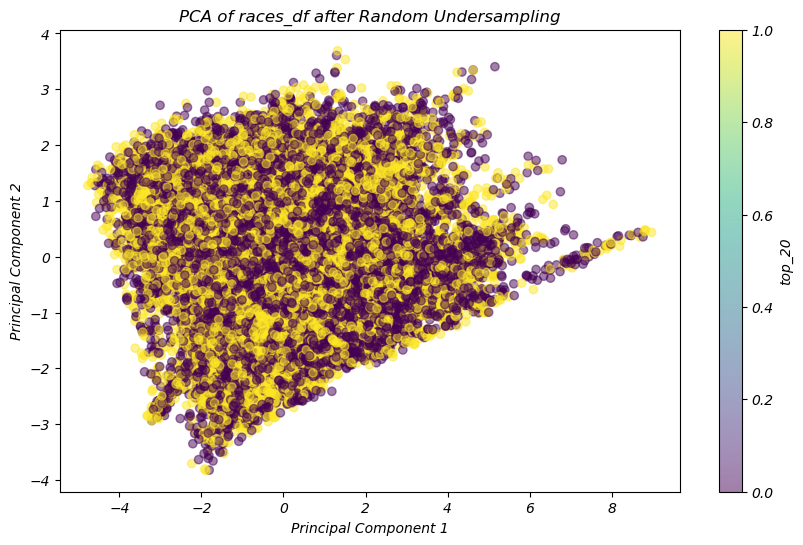

In [6]:
from imblearn.under_sampling import RandomUnderSampler

# Separate features and target
X = races_df.drop(columns=['top_20'])
y = races_df['top_20']

# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Combine the resampled features and target into a new DataFrame
races_resampled_df = pd.DataFrame(X_res, columns=X.columns)
races_resampled_df['top_20'] = y_res

# select data and scale it
features = races_resampled_df.drop(columns=['top_20'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components and plot them
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['top_20'] = races_resampled_df['top_20']

plt.figure(figsize=(10,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['top_20'], cmap='viridis', alpha=0.5)
plt.colorbar(label='top_20')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of races_df after Random Undersampling')
plt.show()


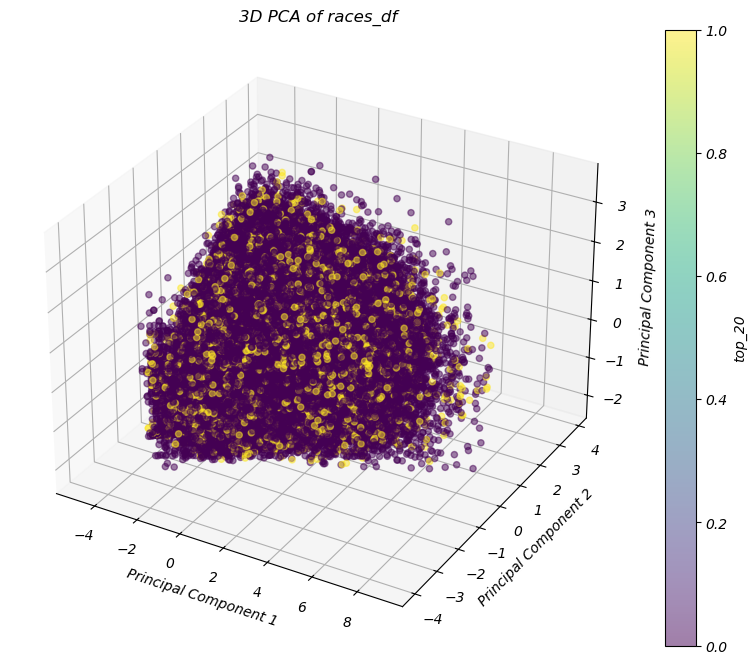

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA with 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components and plot them
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['top_20'] = races_df['top_20']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['top_20'], cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='top_20')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of races_df')
plt.show()


Data not seems to be separated either with undersamplig or in 2 and in 3 dimensions

## Mutual Information

Let's use Mutual Information to try to find some correlation between our features and the target one

In [8]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# compute the mutual information
mi = mutual_info_classif(races_df.drop(columns=["top_20"]), races_df["top_20"], discrete_features="auto")

# create a DataFrame with the mutual information and plot it
mi_df = pd.DataFrame({
    'Feature': races_df.drop(columns=["top_20"]).columns,  # Nomi delle feature (escludendo top_20)
    'Mutual Information': mi
})
mi_df.sort_values(by='Mutual Information', ascending=False, inplace=True)

print(mi_df)

                 Feature  Mutual Information
6         top_20_entropy            0.044429
4  avg_relative_position            0.030856
5       position_entropy            0.011182
2          cyclist_level            0.007017
1            cyclist_age            0.004352
3     cyclist_experience            0.002080
0            climb_total            0.000000


The analysis of Mutual Information (MI) reveals that the dataset features have low predictive power for distinguishing between cyclists in the top 20 and others. Most features show minimal or no correlation with the target, and their distributions overlap significantly between classes, indicating limited discriminative capacity.

## Random Classifier

Here, we randomly assign values to top_20 and then test the best model to determine if it outperforms the original one.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score,  confusion_matrix, get_scorer, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
from imblearn.combine import SMOTETomek

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division

In [10]:
train_labels = train_labels.sample(frac=1, random_state=42).reset_index(drop=True)
test_labels = test_labels.sample(frac=1, random_state=42).reset_index(drop=True)

numeric_transformer = StandardScaler()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, train_data.columns),
    ])

resampling = SMOTETomek(sampling_strategy=0.9, random_state=42)
clf = LGBMClassifier(boosting_type='rf', is_unbalance=True, importance_type='gain', verbose=-1, random_state=0, n_jobs=1)

# Create the model pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampling", resampling),
        ("clf", clf)]
)

# Define the hyperparameter grid
params = {
        'clf__boosting_type': ['gbdt'],
        'clf__n_estimators': [50, 60, 70, 80, 90, 100, 120, 150, 170],
        'clf__learning_rate': [0.0001, 0.0005, 0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'clf__max_depth': [2, 3, 4, 5],
        'clf__reg_lambda': [0.0001, 0.005, 0.001, 0.005, 0.01, 0.1, 0.3, 0.5, 0.7],
        'clf__reg_alpha': [0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7],
        'clf__max_bins': [4, 8, 16, 32, 64, 128, 255],
        'clf__min_child_samples': [5, 10, 15, 20],
        'clf__is_unbalance': [False],
        'clf__importance_type': ['gain'],
        'clf__verbose': [-1],
        'clf__random_state': [0],
        'clf__n_jobs': [1]
}


# Define the scoring functions
scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# Perform randomized search cross-validation
rscv = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    scoring=scoring,
    n_iter=30, 
    cv=5,   # already stratified!
    verbose=1, 
    n_jobs=-1, 
    random_state=42, 
    refit="f1"
    ) 

rscv.fit(train_data, train_labels.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits


d:\miniconda3\envs\HLT\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


KeyboardInterrupt: 

### Validation scores:

In [12]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_index = rscv.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.3099, Std: 0.0076
Specificity - Mean: 0.6956, Std: 0.0053
Accuracy - Mean: 0.6444, Std: 0.0040
Precision - Mean: 0.1349, Std: 0.0020
Recall - Mean: 0.3099, Std: 0.0076
Roc_auc - Mean: 0.5028, Std: 0.0037
F1 - Mean: 0.1879, Std: 0.0031


In [13]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_index = rscv.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.3099, Std: 0.0076
Specificity - Mean: 0.6956, Std: 0.0053
Accuracy - Mean: 0.6444, Std: 0.0040
Precision - Mean: 0.1349, Std: 0.0020
Recall - Mean: 0.3099, Std: 0.0076
Roc_auc - Mean: 0.5028, Std: 0.0037
F1 - Mean: 0.1879, Std: 0.0031


### Test scores:

Accuracy: 0.664
Recall: 0.28
Precision: 0.151
Sensitivity: 0.28
Specificity: 0.73
F1 Score: 0.196
ROC AUC Score: 0.505


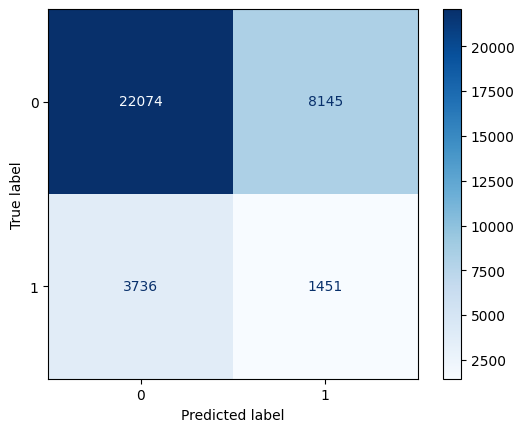

In [14]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [15]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.73      0.79     30219
           1       0.15      0.28      0.20      5187

    accuracy                           0.66     35406
   macro avg       0.50      0.51      0.49     35406
weighted avg       0.75      0.66      0.70     35406



The best model outperforms the random classifier in accuracy, specificity, and AUC, but still struggles with sensitivity and precision. However, the random classifier is not much worse, suggesting that the main issue lies in the imbalanced dataset and the difficulty in separating the classes. This indicates that the challenges stem more from the dataset structure than the models themselves given that all the models were tried with different resempler, different class weights...

## **Strategy and Performance Variability in Professional Cycling**

What we want to show with this analysis is that cycling is a very strategic sport, and stage races can often be won without good placings in all stages. Furthermore, for this type of race, positioning is not always indicative because for cyclists aiming to win the compplssive race (e.g. Giro di Italia) what counts is the final time accumulated in the stages. Consequently, in some stages one can also arrive in very backward positions trying not to accumulate too large a gap from the leaders.<br>
Our classification algorithms work on the stages independently without considering the accumulated times and this is certainly a cause of the classifiers not working properly

In [37]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_data["top_20"] = train_labels["top_20"]

In [38]:
import re

# Extract the year from the URL using regex
train_data['year'] = train_data['_url'].apply(lambda x: int(re.search(r'/(\d{4})/', x).group(1)))

### **1. Cyclists who won the Giro d'Italia**
- Select **2 cyclists** who won the Giro d'Italia (Vincenzo Nibali 2013 and )
- Analyze their performance in the **individual stages** of the Giro during the year they won.
- Extend the analysis to their performance in **other races** during the same year.

#### Vincenzo Nibali: winner of the giro di italia in 2013

In [39]:
cyclist = train_data[(train_data['cyclist'] == 'vincenzo-nibali') & (train_data['year'] == 2013)]
all_positions =  cyclist[['position', '_url']]

cyclist = cyclist[cyclist['_url'].str.contains('giro-d-italia/2013')]
positions = cyclist[['position', '_url', 'cyclist']]
print(positions)

        position                         _url          cyclist
332262        28   giro-d-italia/2013/stage-1  vincenzo-nibali
332263        16   giro-d-italia/2013/stage-3  vincenzo-nibali
332264        12   giro-d-italia/2013/stage-4  vincenzo-nibali
332265        20   giro-d-italia/2013/stage-5  vincenzo-nibali
332266        36   giro-d-italia/2013/stage-6  vincenzo-nibali
332267        22   giro-d-italia/2013/stage-7  vincenzo-nibali
332268         3   giro-d-italia/2013/stage-8  vincenzo-nibali
332269         9   giro-d-italia/2013/stage-9  vincenzo-nibali
332270         2  giro-d-italia/2013/stage-10  vincenzo-nibali
332271        31  giro-d-italia/2013/stage-11  vincenzo-nibali
332272        38  giro-d-italia/2013/stage-12  vincenzo-nibali
332273        49  giro-d-italia/2013/stage-13  vincenzo-nibali
332274         1  giro-d-italia/2013/stage-14  vincenzo-nibali
332275         6  giro-d-italia/2013/stage-15  vincenzo-nibali
332276        11  giro-d-italia/2013/stage-16  vincenzo

In [40]:
# the 5 worst positions in that year
worst_positions = all_positions.nlargest(5, 'position')
print(worst_positions)

        position                            _url
332255        53  tirreno-adriatico/2013/stage-2
332273        49     giro-d-italia/2013/stage-13
332280        44     giro-d-italia/2013/stage-21
332272        38     giro-d-italia/2013/stage-12
332266        36      giro-d-italia/2013/stage-6


#### Alberto Contado: winner of the giro di italia in 2015

In [41]:
cyclist = train_data[(train_data['cyclist'] == 'alberto-contador') & (train_data['year'] == 2015)]
all_positions =  cyclist[['position', '_url']]

cyclist = cyclist[cyclist['_url'].str.contains('giro-d-italia/2015')]
positions = cyclist[['position', '_url', 'cyclist']]
print(positions)

      position                         _url           cyclist
5429        23   giro-d-italia/2015/stage-2  alberto-contador
5430        18   giro-d-italia/2015/stage-3  alberto-contador
5431         8   giro-d-italia/2015/stage-4  alberto-contador
5432         3   giro-d-italia/2015/stage-5  alberto-contador
5433       133   giro-d-italia/2015/stage-6  alberto-contador
5434        29   giro-d-italia/2015/stage-7  alberto-contador
5435         4   giro-d-italia/2015/stage-8  alberto-contador
5436        10   giro-d-italia/2015/stage-9  alberto-contador
5437        30  giro-d-italia/2015/stage-10  alberto-contador
5438        19  giro-d-italia/2015/stage-11  alberto-contador
5439         1  giro-d-italia/2015/stage-12  alberto-contador
5440        45  giro-d-italia/2015/stage-13  alberto-contador
5441         2  giro-d-italia/2015/stage-14  alberto-contador
5442         2  giro-d-italia/2015/stage-15  alberto-contador
5443         2  giro-d-italia/2015/stage-16  alberto-contador
5444    

In [42]:
# the 5 worst positions in that year
worst_positions = all_positions.nlargest(5, 'position')
print(worst_positions)

      position                            _url
5433       133      giro-d-italia/2015/stage-6
5427        90  volta-a-catalunya/2015/stage-6
5468        90    tour-de-france/2015/stage-21
5415        66  tirreno-adriatico/2015/stage-1
5455        59     tour-de-france/2015/stage-7


### **2. Cyclists who won the Tour de France**
- Select **2 cyclists** who won the Tour de France.
- Examine their performance in the **individual stages** of the Tour during the year they won.
- Compare this with their results in **other competitions** from the same year.

#### Christopher Froome: winner of the Tour de France in 2016

In [43]:
cyclist = train_data[(train_data['cyclist'] == 'christopher-froome') & (train_data['year'] == 2016)]
all_positions =  cyclist[['position', '_url']]

cyclist = cyclist[cyclist['_url'].str.contains('tour-de-france/2016')]
positions = cyclist[['position', '_url', 'cyclist']]
print(positions)

       position                          _url             cyclist
55179        24   tour-de-france/2016/stage-1  christopher-froome
55180         9   tour-de-france/2016/stage-2  christopher-froome
55181        21   tour-de-france/2016/stage-3  christopher-froome
55182        36   tour-de-france/2016/stage-4  christopher-froome
55183         8   tour-de-france/2016/stage-5  christopher-froome
55184        23   tour-de-france/2016/stage-6  christopher-froome
55185        10   tour-de-france/2016/stage-7  christopher-froome
55186         0   tour-de-france/2016/stage-8  christopher-froome
55187        10   tour-de-france/2016/stage-9  christopher-froome
55188        24  tour-de-france/2016/stage-10  christopher-froome
55189         1  tour-de-france/2016/stage-11  christopher-froome
55190        24  tour-de-france/2016/stage-12  christopher-froome
55191         1  tour-de-france/2016/stage-13  christopher-froome
55192        59  tour-de-france/2016/stage-14  christopher-froome
55193     

In [44]:
# the 5 worst positions in that year
worst_positions = all_positions.nlargest(5, 'position')
print(worst_positions)

       position                              _url
55199       137      tour-de-france/2016/stage-21
55164       111  liege-bastogne-liege/2016/result
55170       104     tour-de-romandie/2016/stage-5
55167        98     tour-de-romandie/2016/stage-2
55165        59    tour-de-romandie/2016/prologue


#### Egan Bernal: winner of the Tour de France in 2019

In [45]:
cyclist = train_data[(train_data['cyclist'] == 'egan-bernal') & (train_data['year'] == 2019)]
all_positions =  cyclist[['position', '_url']]

cyclist = cyclist[cyclist['_url'].str.contains('tour-de-france/2019')]
positions = cyclist[['position', '_url', 'cyclist']]
print(positions)


       position                          _url      cyclist
85367        80   tour-de-france/2019/stage-1  egan-bernal
85368        11   tour-de-france/2019/stage-3  egan-bernal
85369        22   tour-de-france/2019/stage-4  egan-bernal
85370        44   tour-de-france/2019/stage-5  egan-bernal
85371        11   tour-de-france/2019/stage-6  egan-bernal
85372        23   tour-de-france/2019/stage-7  egan-bernal
85373         8   tour-de-france/2019/stage-8  egan-bernal
85374        47   tour-de-france/2019/stage-9  egan-bernal
85375        13  tour-de-france/2019/stage-10  egan-bernal
85376        12  tour-de-france/2019/stage-11  egan-bernal
85377        27  tour-de-france/2019/stage-12  egan-bernal
85378        21  tour-de-france/2019/stage-13  egan-bernal
85379         4  tour-de-france/2019/stage-14  egan-bernal
85380         4  tour-de-france/2019/stage-15  egan-bernal
85381        27  tour-de-france/2019/stage-16  egan-bernal
85382        38  tour-de-france/2019/stage-17  egan-bern

In [46]:
# the 5 worst positions in that year
worst_positions = all_positions.nlargest(5, 'position')
print(worst_positions)

       position                            _url
85367        80     tour-de-france/2019/stage-1
85355        68  volta-a-catalunya/2019/stage-5
85361        53     tour-de-suisse/2019/stage-4
85374        47     tour-de-france/2019/stage-9
85345        44         paris-nice/2019/stage-3


### **3. Cyclists who placed 5th in the Giro d'Italia**
- Choose **2 cyclists** who finished **5th in the Giro d'Italia** (Domenico Pozzovivo and )
- Investigate their stage-by-stage performance in the Giro for that year.
- Include an analysis of their results in **other races** from the same year.

#### Domenico Pozzovivo: 5th place at the Giro d'Italia in 2014

In [47]:
cyclist = train_data[(train_data['cyclist'] == 'domenico-pozzovivo') & (train_data['year'] == 2014)]
all_positions =  cyclist[['position', '_url']]

cyclist = cyclist[cyclist['_url'].str.contains('giro-d-italia/2014')]
positions = cyclist[['position', '_url', 'cyclist']]
print(positions)

       position                         _url             cyclist
80189       131   giro-d-italia/2014/stage-2  domenico-pozzovivo
80190        86   giro-d-italia/2014/stage-3  domenico-pozzovivo
80191       159   giro-d-italia/2014/stage-4  domenico-pozzovivo
80192         8   giro-d-italia/2014/stage-5  domenico-pozzovivo
80193        13   giro-d-italia/2014/stage-6  domenico-pozzovivo
80194        27   giro-d-italia/2014/stage-7  domenico-pozzovivo
80195         6   giro-d-italia/2014/stage-8  domenico-pozzovivo
80196         2   giro-d-italia/2014/stage-9  domenico-pozzovivo
80197        61  giro-d-italia/2014/stage-10  domenico-pozzovivo
80198        25  giro-d-italia/2014/stage-11  domenico-pozzovivo
80199         8  giro-d-italia/2014/stage-12  domenico-pozzovivo
80200        51  giro-d-italia/2014/stage-13  domenico-pozzovivo
80201        16  giro-d-italia/2014/stage-14  domenico-pozzovivo
80202        11  giro-d-italia/2014/stage-15  domenico-pozzovivo
80203         4  giro-d-i

In [48]:
# the 5 worst positions in that year
worst_positions = all_positions.nlargest(5, 'position')
print(worst_positions)

       position                            _url
80191       159      giro-d-italia/2014/stage-4
80189       131      giro-d-italia/2014/stage-2
80181       112  volta-a-catalunya/2014/stage-1
80190        86      giro-d-italia/2014/stage-3
80210        84        il-lombardia/2014/result


#### Ivan Basso: 5th place at the Giro d'Italia 2012

In [49]:
cyclist = train_data[(train_data['cyclist'] == 'ivan-basso') & (train_data['year'] == 2012)]
all_positions =  cyclist[['position', '_url']]

cyclist = cyclist[cyclist['_url'].str.contains('giro-d-italia/2012')]
positions = cyclist[['position', '_url', 'cyclist']]
print(positions)

        position                         _url     cyclist
136549        34   giro-d-italia/2012/stage-1  ivan-basso
136550        98   giro-d-italia/2012/stage-2  ivan-basso
136551       100   giro-d-italia/2012/stage-3  ivan-basso
136552        63   giro-d-italia/2012/stage-5  ivan-basso
136553        61   giro-d-italia/2012/stage-6  ivan-basso
136554         7   giro-d-italia/2012/stage-7  ivan-basso
136555        15   giro-d-italia/2012/stage-8  ivan-basso
136556        39   giro-d-italia/2012/stage-9  ivan-basso
136557        14  giro-d-italia/2012/stage-10  ivan-basso
136558        70  giro-d-italia/2012/stage-11  ivan-basso
136559        39  giro-d-italia/2012/stage-12  ivan-basso
136560        52  giro-d-italia/2012/stage-13  ivan-basso
136561        12  giro-d-italia/2012/stage-14  ivan-basso
136562         5  giro-d-italia/2012/stage-15  ivan-basso
136563        47  giro-d-italia/2012/stage-16  ivan-basso
136564         1  giro-d-italia/2012/stage-17  ivan-basso
136565        

In [50]:
# the 5 worst positions in that year
worst_positions = all_positions.nlargest(5, 'position')
print(worst_positions)

        position                            _url
136581       128    tour-de-france/2012/stage-12
136543       122  tour-de-romandie/2012/prologue
136582       120    tour-de-france/2012/stage-13
136541       113         paris-nice/2012/stage-4
136539       111         paris-nice/2012/stage-2


### **4. Cyclists who placed 5th in the Tour de France**
- Select **2 cyclists** who finished **5th in the Tour de France**.
- Analyze their performance across the stages of the Tour for that year.
- Review their results in **other competitions** from the same year.

#### Fabio Aru: 5th place at the Tour de France in 2017

In [51]:
cyclist = train_data[(train_data['cyclist'] == 'fabio-aru') & (train_data['year'] == 2017)]
all_positions =  cyclist[['position', '_url']]

cyclist = cyclist[cyclist['_url'].str.contains('tour-de-france/2017')]
positions = cyclist[['position', '_url', 'cyclist']]
print(positions)

       position                          _url    cyclist
94563        65   tour-de-france/2017/stage-1  fabio-aru
94564        59   tour-de-france/2017/stage-2  fabio-aru
94565        16   tour-de-france/2017/stage-3  fabio-aru
94566        25   tour-de-france/2017/stage-4  fabio-aru
94567         0   tour-de-france/2017/stage-5  fabio-aru
94568        38   tour-de-france/2017/stage-6  fabio-aru
94569        52   tour-de-france/2017/stage-7  fabio-aru
94570         5   tour-de-france/2017/stage-8  fabio-aru
94571         4   tour-de-france/2017/stage-9  fabio-aru
94572        34  tour-de-france/2017/stage-10  fabio-aru
94573        33  tour-de-france/2017/stage-11  fabio-aru
94574         2  tour-de-france/2017/stage-12  fabio-aru
94575         8  tour-de-france/2017/stage-13  fabio-aru
94576        29  tour-de-france/2017/stage-14  fabio-aru
94577        30  tour-de-france/2017/stage-15  fabio-aru
94578        17  tour-de-france/2017/stage-16  fabio-aru
94579         9  tour-de-france

In [52]:
# the 5 worst positions in that year
worst_positions = all_positions.nlargest(5, 'position')
print(worst_positions)

       position                           _url
94563        65    tour-de-france/2017/stage-1
94581        60   tour-de-france/2017/stage-19
94564        59    tour-de-france/2017/stage-2
94602        59  vuelta-a-espana/2017/stage-20
94583        57   tour-de-france/2017/stage-21


#### Tejay Van Garderen: 5th place at the Tour de France in 2012

In [53]:
cyclist = train_data[(train_data['cyclist'] == 'tejay-van-garderen') & (train_data['year'] == 2012)]
all_positions =  cyclist[['position', '_url']]

cyclist = cyclist[cyclist['_url'].str.contains('tour-de-france/2012')]
positions = cyclist[['position', '_url', 'cyclist']]
print(positions)

        position                          _url             cyclist
315264         3  tour-de-france/2012/prologue  tejay-van-garderen
315265        20   tour-de-france/2012/stage-1  tejay-van-garderen
315266        40   tour-de-france/2012/stage-2  tejay-van-garderen
315267        15   tour-de-france/2012/stage-3  tejay-van-garderen
315268       120   tour-de-france/2012/stage-4  tejay-van-garderen
315269        36   tour-de-france/2012/stage-5  tejay-van-garderen
315270        38   tour-de-france/2012/stage-6  tejay-van-garderen
315271        45   tour-de-france/2012/stage-7  tejay-van-garderen
315272        17   tour-de-france/2012/stage-8  tejay-van-garderen
315273         3   tour-de-france/2012/stage-9  tejay-van-garderen
315274        26  tour-de-france/2012/stage-10  tejay-van-garderen
315275        11  tour-de-france/2012/stage-11  tejay-van-garderen
315276        20  tour-de-france/2012/stage-12  tejay-van-garderen
315277        19  tour-de-france/2012/stage-13  tejay-van-gard

In [54]:
# the 5 worst positions in that year
worst_positions = all_positions.nlargest(5, 'position')
print(worst_positions)

        position                              _url
315268       120       tour-de-france/2012/stage-4
315258        73     la-fleche-wallone/2012/result
315259        60  liege-bastogne-liege/2012/result
315278        49      tour-de-france/2012/stage-14
315284        46      tour-de-france/2012/stage-20


### **The results of the analysis**

As a preamble, it must be specified that these observations are not a rigorous statistical demonstration. However, considering that the selected cyclists were chosen randomly from among those who fulfil the requirements for our analysis (e.g. having won a Giro d'Italia), we can still say that they are relevant.<br>

From **analysis 1 and 2**, we can observe that cyclists who have won the Giro d'Italia and the Tour de France have still achieved very high placements in certain stages of the race itself, even finishing well beyond the 100th position in some cases. It can be observed that even in other competitions throughout the year their placements were far from exceptional. 

The same observation can be made for the cyclists who reached fifth position overall (**analysis 3 and 4**), who recorded very high rankings (bad) despite their good overall position.

AGGIUNGERE COMMENTO: calcolo dei ciclsiti dopo i top 20 e anche scrivere posizione genrale. 